In [2]:
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML
from pysit.util.util import *
from cycler import cycler
import h5py
import string

Limited tf.compat.v2.summary API due to missing TensorBoard installation
Limited tf.summary API due to missing TensorBoard installation


In [3]:
%matplotlib inline

In [4]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import copy as copy
import math
import os
import scipy.io as sio
from scipy.signal import hilbert
from shutil import copy2

import sys

from pysit import *
from pysit.gallery import horizontal_reflector
from pysit.gallery.layered_medium import three_layered_medium
from pysit.util.io import *
from pysit.util.compute_tools import *

from pysit.util.parallel import *

from mpi4py import MPI
from FTools.compute_adjoint_source import *
from FTools.compute_IC import *
from FTools.fang_plot import *


In [5]:
def Envelopt_fun(dobs, dpred, p=2.0):
    dpred_Hilbert = hilbert(dpred, axis=0).imag
    dobs_Hilbert = hilbert(dobs, axis=0).imag

    dpred_envelope = dpred**2.0 + dpred_Hilbert**2.0
    dobs_envelope = dobs**2.0 + dobs_Hilbert**2.0

    resid = dpred_envelope**(p/2.0) - dobs_envelope**(p/2.0)
    
    denvelope_ddata = p * dpred_envelope**(p/2.0 - 1.0) * dpred
    adjoint_src = denvelope_ddata * resid

    denvelope_ddataH = p * dpred_envelope**(p/2.0 - 1.0) * dpred_Hilbert 
    adjoint_src += (-hilbert(denvelope_ddataH * resid, axis=0)).imag
    
    return -resid, -adjoint_src

def Correlate_fun(dobs, dpred, dt):
    shape_dobs = np.shape(dobs)
    n_correlate_data = shape_dobs[0]
    resid = np.zeros([n_correlate_data, shape_dobs[1]])
    adjoint_src = np.zeros([shape_dobs[0], shape_dobs[1]])
    W  = np.zeros(n_correlate_data)
    if np.mod(n_correlate_data, 2) == 0:
        W[0:n_correlate_data//2] = np.linspace(-dt, -dt*(shape_dobs[0])/2.0, n_correlate_data/2)
        W[n_correlate_data//2:n_correlate_data] = np.flipud(W[0:n_correlate_data//2])
    else:
        W[0:(n_correlate_data+1)//2] = np.linspace(0.0, -dt*(shape_dobs[0]-1)/2.0, (n_correlate_data+1)/2)
        W[(n_correlate_data-1)//2:n_correlate_data] = np.flipud(W[0:(n_correlate_data+1)//2])
        
    for i in range(0, shape_dobs[1]):
        correlate_data = correlate_fun(dobs[:,i], dpred[:,i])
        Wf = W * correlate_data
        correlate_data_norm2 = np.dot(correlate_data, correlate_data)
        Wf_norm2 = np.dot(Wf, Wf)
        resid[:, i] = Wf / np.sqrt(correlate_data_norm2)
            
        adjoint_src[:,i] = (2.0*correlate_data_norm2*correlate_fun(dobs[:,i], W*Wf, mode='adj') - 2.0*Wf_norm2*correlate_fun(dobs[:,i], correlate_data, mode='adj')) / correlate_data_norm2**2.0
    
    return resid, -1*adjoint_src


In [6]:
def optimal_transport_fwi2(dobs, dpred, dt, transform_mode='linear', c_ratio=5.0, exp_a=1.0):

    ## Transform_mode: linear, quadratic, absolute, exponential
    
    # Normalization and transfer data to a distribution
    c = c_ratio * np.abs(np.max(np.abs(dobs)))

        

    if transform_mode == 'linear':          
        if c < np.abs(np.min(dpred)):
            pass
#             print('c {0}'.format(c))
#             print('min dpred {0}'.format(np.min(dpred)))


        g = dobs + c
        g = g / (np.sum(g)*dt)
        f_plus_c = dpred + c
        s = (np.sum(f_plus_c)*dt)
        f = f_plus_c / s
    elif transform_mode == 'quadratic':
        g = dobs ** 2.0
        g = g / (np.sum(g)*dt)
        f_quadr = dpred ** 2.0
        s = np.sum(f_quadr)*dt
        f = f_quadr / s
    elif transform_mode == 'absolute':
        g = np.abs(dobs)
        g = g / (np.sum(g)*dt)
        f_abs = np.abs(dpred)
        s = np.sum(f_abs)*dt
        f = f_abs / s
    elif transform_mode == 'exponential':
        g = np.exp(dobs * exp_a)
        g = g / (np.sum(g)*dt)
        f_exp = np.exp(dpred * exp_a)
        s = np.sum(f_exp)*dt
        f = f_exp / s
    
    f[np.where(np.abs(f)<1e-20)] = 0.0
    g[np.where(np.abs(g)<1e-20)] = 0.0
    ndata = len(f)
    t = np.array(range(0,ndata)) * dt
    
#     if transform_mode == 'linear': 
#         if c < np.abs(np.min(dpred)):
#             print('min f {0}'.format(np.min(f)))
#             print('min g {0}'.format(np.min(g)))

    F = np.zeros(ndata)
    G = np.zeros(ndata)
    g_IGoF = np.zeros(ndata)
    IGoF = np.zeros(ndata)
    IGoF_ind = np.zeros(ndata)

    # Compute F(t) and G(t)
    int_f = 0.0
    int_g = 0.0
    for i in range(0, ndata):
        int_f += f[i]
        int_g += g[i]
        F[i] = int_f
        G[i] = int_g

    # Compute G^{-1} o F(t)
    # IGoF[ndata-1] = (ndata-1)*dt
    # IGoF_ind[ndata-1] = ndata-1

    IGoF = np.interp(F, G, t)
    
    return IGoF,F,G




In [7]:
def optimal_transport_fwi3(dobs, dpred, dt, transform_mode='linear', c_ratio=5.0, exp_a=1.0, env_p=2.0, npad=0):

    ## Transform_mode: linear, quadratic, absolute, exponential
    
    # Normalization and transfer data to a distribution
    c = c_ratio * np.abs(np.max(np.abs(dobs)))
#     dobs = padding_zeros_fun(dobs, len(dobs), npad, npad)
#     dpred = padding_zeros_fun(dpred, len(dpred), npad, npad)
    

        

    if transform_mode == 'linear':          
        # if c < np.abs(np.min(dpred)):
        #     print('c {0}'.format(c))
        #     print('min dpred {0}'.format(np.min(dpred)))

        g = dobs + c
        g = g / (np.sum(g)*dt)
        f_plus_c = dpred + c
        s = (np.sum(f_plus_c)*dt)
        f = f_plus_c / s
    elif transform_mode == 'quadratic':
        g = dobs ** 2.0
        g = g / (np.sum(g)*dt)
        f_quadr = dpred ** 2.0
        s = np.sum(f_quadr)*dt
        f = f_quadr / s
    elif transform_mode == 'absolute':
        g = np.abs(dobs)
        g = g / (np.sum(g)*dt)
        f_abs = np.abs(dpred)
        s = np.sum(f_abs)*dt
        f = f_abs / s
    elif transform_mode == 'exponential':
        g = np.exp(dobs * exp_a)
        g = g / (np.sum(g)*dt)
        f_exp = np.exp(dpred * exp_a)
        s = np.sum(f_exp)*dt
        f = f_exp / s
    elif transform_mode == 'envelope':
        g, df_envo = envelope_fun(dobs, env_p)
        g = g / (np.sum(g)*dt)
        f_env, df_env = envelope_fun(dpred, env_p)
        s = np.sum(f_env)*dt
        f = f_env / s

    if np.min(f) < 0:
        resid = 1e10
        adj_src = np.zeros(dpred.shape)
        # print('small c used')
        return resid, adj_src, np.linalg.norm(resid)**2.0


    f[np.where(np.abs(f)<1e-20)] = 0.0
    g[np.where(np.abs(g)<1e-20)] = 0.0
    ndata = len(f)
    t = np.array(range(0,ndata)) * dt
    
#     if transform_mode == 'linear': 
#         if c < np.abs(np.min(dpred)):
#             print('min f {0}'.format(np.min(f)))
#             print('min g {0}'.format(np.min(g)))

    F = np.zeros(ndata)
    G = np.zeros(ndata)
    g_IGoF = np.zeros(ndata)
    IGoF = np.zeros(ndata)
    IGoF_ind = np.zeros(ndata)

    # Compute F(t) and G(t)
    int_f = 0.0
    int_g = 0.0
    for i in range(0, ndata):
        int_f += f[i]
        int_g += g[i]
        F[i] = int_f
        G[i] = int_g

    # Compute G^{-1} o F(t)
    # IGoF[ndata-1] = (ndata-1)*dt
    # IGoF_ind[ndata-1] = ndata-1

    IGoF = np.interp(F, G, t)
    g_IGoF = np.interp(IGoF, t, g)

    # IGoF_ind = IGoF_ind.astype(int)
    # # F[ndata-1] = G[ndata-1]
    # F[np.where(F>G[ndata-1])] = G[ndata-1]-10**(-10)
    # for i in range(0, ndata):

    #     IGoF_ind[i] = int(np.searchsorted(G, F[i]))
    #     if IGoF_ind[i] == ndata:
    #         # print('F: ',F)
    #         # print('G: ',G[ndata-1])
    #         # print('Dpred: ', dpred)
    #         IGoF_ind[i] = ndata-1

    #     if IGoF_ind[i] == 0:
    #         IGoF[i] = IGoF_ind[i] * dt
    #         g_IGoF[i] = g[0]
    #     else:
    #         beta = (G[IGoF_ind[i]] - F[i]) / (G[IGoF_ind[i]] - G[IGoF_ind[i]-1])
    #         IGoF[i] = (IGoF_ind[i] - beta) * dt
    #         g_IGoF[i] = g[IGoF_ind[i]] - beta * (g[IGoF_ind[i]] - g[IGoF_ind[i]-1])


    # idx = np.where(IGoF_ind>ndata-1)
    # IGoF_ind[idx] = ndata-1
    # if c < np.abs(np.min(dpred)):
    #     print('min IGoF_ind {0}'.format(np.min(IGoF_ind)))
    #     print('max IGoF_ind {0}'.format(np.max(IGoF_ind)))

    # Compute residual
    t_minus_IGoF = t - IGoF
    resid = np.sqrt(f) * t_minus_IGoF
#    print('min resid {0}'.format(np.min(resid)))
#    print('max resid {0}'.format(np.max(resid)))

    # Compute adjoint source

    adj_src1 = t_minus_IGoF * t_minus_IGoF
    # adj_src2 = (-2*f*dt / g[IGoF_ind]) * t_minus_IGoF
    f_divid_g = np.zeros(ndata)
    idx_gnot0 = np.where(g_IGoF > 0)
    f_divid_g[idx_gnot0] = -2*f[idx_gnot0]*dt / g_IGoF[idx_gnot0]

    adj_src2 = f_divid_g * t_minus_IGoF

    for i in range(ndata-2, -1, -1):
        adj_src2[i] += adj_src2[i+1]

    adj_src = adj_src1+adj_src2
    

    if transform_mode == 'linear':
        adj_src = adj_src / s - (dt/(s**2.0)*np.dot(f_plus_c, adj_src))*np.ones(ndata)
    elif transform_mode == 'quadratic':
        adj_src = (adj_src / s - (dt/(s**2.0)*np.dot(f_quadr, adj_src))*np.ones(ndata))*2.0*dpred
        # adj_src = adj_src / s - (dt/(s**2.0)*np.dot(f_quadr, adj_src))*2.0*dpred
    elif transform_mode == 'absolute':
        adj_src = (adj_src / s - (dt/(s**2.0)*np.dot(f_abs, adj_src))*np.ones(ndata))*np.sign(dpred)
    elif transform_mode == 'exponential':
        adj_src = (adj_src / s - (dt/(s**2.0)*np.dot(f_exp, adj_src))*np.ones(ndata))*(np.exp(dpred*exp_a) * exp_a)
    elif transform_mode == 'envelope':
        adj_src = (adj_src / s - (dt/(s**2.0)*np.dot(f_env, adj_src)) * np.ones(ndata))*(df_env)

#     adj_src = un_padding_zeros_fun(adj_src, len(dobs)-2*npad, npad, npad)

    return resid, adj_src, np.linalg.norm(resid)**2.0

In [8]:
def plot_models2(Vels, Titles, cmap='jet'):
    n_v = len(Vels)
    n_col = 2
    n_row = n_v // n_col
    
    fig,ax = plt.subplots(n_row,n_col,figsize=(20,4*n_row))
    k = 0
    v_out = []
    for i in range(0,2):
        for j in range(0,n_row):
            vi = Vels[k]
            om = [0.0, 0.0]
            dm = [0.01, 0.01]
            nm = np.shape(vi)
            output = odn2grid(om, dm, nm)
            Depth = output[0]
            Lateral = output[1]
            clim_v = [1.5,5.5]
            plot_model(fig, ax[j][i], vi, Lateral, Depth, nm, clim=clim_v, title_str=Titles[k], cmap=cmap)
            k += 1
            
    return fig
    
        
    

In [9]:
def plot_trace(Vels, Legends, trace):
    fig = plt.figure()
    om = [0.0, 0.0]
    dm = [0.01, 0.01]
    nm = np.shape(Vels[0])
    output = odn2grid(om, dm, nm)
    Depth = output[0]
    Lateral = output[1] 
    for i in range(len(Legends)):
        vi = Vels[i]
        plt.plot(Depth, vi[:,trace])
        plt.title('x = ' + str(dm[0]*(trace-1)) +' km' )
        
    plt.legend(Legends)
    
    return fig
        
        

In [10]:
def Compute_wavefields(ExpDir, idx):
    o_org = np.array([0.0,0.0])
    d_org = np.array([0.02, 0.02]);
    model_size_phy_org = np.array([6.0, 3.0])
    n_org = np.floor(model_size_phy_org/d_org)
    n_org = n_org.astype(int) + 1
    vel_true = 2.5
    output = odn2grid(o_org, d_org, n_org)
    Depth = output[0]
    Lateral = output[1]
    vt = np.ones(n_org) * vel_true
    vt = vt.transpose()
    vt = np.reshape(vt, (np.prod(n_org), 1))

    pmlx = PML(0.5, 100)
    pmlz = PML(0.5, 100)

    x_config = (0.0, model_size_phy_org[1], pmlx, pmlx)
    z_config = (0.0, model_size_phy_org[0], pmlz, pmlz)

    d = RectangularDomain(x_config, z_config)
    m = CartesianMesh(d, n_org[1], n_org[0])
    
    C, C0, m, d = horizontal_reflector(m)

    C.data = vt

    model_size = m._shapes[False,True]
    model_delta = m.deltas

    # xrec_multiple = np.array(range(10, model_size[0]-10)) * model_delta[0]
    # xsrc_multiple = np.linspace(xrec_multiple[0], xrec_multiple[-1], num=10)
    xsrc_multiple = [1.5]
    xrec_multiple = [1.5]
    print(xsrc_multiple)
    zsrc_multiple = 0.5
    zrec_multiple = 5.5
    shots = equispaced_acquisition_given_locations(m,
                                                   RickerWavelet(8.0),
                                                   sources_x_locations=xsrc_multiple,
                                                   source_depth=zsrc_multiple,
                                                   source_kwargs={},
                                                   receivers_x_locations=xrec_multiple,
                                                   receiver_depth=zrec_multiple
                                                   )

    
    # Define and configure the wave solver
    trange = (0.0,4.0)
                                   
    solver = ConstantDensityAcousticWave(m,
                                         spatial_accuracy_order=4,
                                         trange=trange,
                                         kernel_implementation='cpp',
                                         max_C=3.2)

    solver.max_C = 3.2
                                   
    # Generate synthetic Seismic data
    tt = time.time()
    base_model = solver.ModelParameters(m,{'C': C})
    print('strat generate data')

    generate_seismic_data(shots, solver, base_model)
                                   
    print('Data generation: {0}s'.format(time.time()-tt))
    
    Dobs = shots[0].receivers.data
    Dpred = []
    
    for i in idx:
        print(i)
        fname = ExpDir + '/x_' + str(i) + '.mat'
        data = sio.loadmat(fname)['data']
        C.data = data
        base_model = solver.ModelParameters(m,{'C': C})
        generate_seismic_data(shots, solver, base_model)
        Dpred.append(shots[0].receivers.data)
        
    
    return Dobs, Dpred
        
        
        
    

In [11]:
def create_animation_single(vt, fwave, Lateral, Depth, model_size, ntime, climc=None, ksmp=50):
    plt.figure()
    fig, ax = plt.subplots(1,2,figsize=(12,6))

    ims = []
    model_sizet = model_size
    model_sizec = [model_size[1], model_size[0]]
    DD = np.zeros(model_sizet)
    EE = np.zeros(model_sizet)
    vt = np.reshape(vt, model_size)
#     vt = np.transpose(vt)
    for i in range(0,ntime,ksmp):    
        A = np.reshape(fwave[i], model_sizec)
        A = np.transpose(A)
        
        ax[0].set_title('Final model')
        ax[0].set_xlabel('X [km]')
        ax[0].set_ylabel('Z [km]')
        im0=ax[0].imshow(vt, clim=climc[0], 
                            extent=[Lateral[0], Lateral[model_size[1]-1], Depth[model_size[0]-1], Depth[0]],
                            animated=True)   
        im0.set_cmap('jet')
        
        ax[1].set_title('Final wavefield')
        ax[1].set_xlabel('X [km]')
        ax[1].set_ylabel('Z [km]')
        im2=ax[1].imshow(A,clim=climc[1], 
                            extent=[Lateral[0], Lateral[model_size[1]-1], Depth[model_size[0]-1], Depth[0]],
                            animated=True)
        im2.set_cmap('jet')
        
        
        ims.append([im0,im2])

    ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True, repeat_delay=1000)
    plt.close()
    
    return ani

In [12]:
def create_animation_model_update(Dirs, Titles, ntime=100, ksmp=1):
    plt.figure()
    ncol = 2
    nrow = len(Dirs) // 2
    climc = [1.5,5.5]
    fig, ax = plt.subplots(nrow, ncol, figsize=(12,6*nrow))
    Lateral = [0.0, 4.6]
    Depth = [0.0, 1.5]

    ims = []
#     vt = np.transpose(vt)
    for i in range(0,ntime,ksmp):    
        
        fname = Dirs[0] + '/x_'+str(i)+'.mat'
        data = sio.loadmat(fname)['data']
        vi0  = np.reshape(data,(563,251))
        vi0  = vi0.transpose()
        vi0  = vi0[50:201, 50:513]
        
        
        ax[0].set_title(Titles[0])
        ax[0].set_xlabel('X [km]')
        ax[0].set_ylabel('Z [km]')
        im0=ax[0].imshow(vi0, clim=climc, 
                            extent=[Lateral[0], Lateral[-1], Depth[-1], Depth[0]],
                            animated=True)   
        im0.set_cmap('jet')
        
        fname = Dirs[1] + '/x_'+str(i)+'.mat'
        data = sio.loadmat(fname)['data']
        vi1  = np.reshape(data,(563,251))
        vi1  = vi1.transpose()
        vi1  = vi1[50:201, 50:513]
        
        ax[1].set_title(Titles[1])
        ax[1].set_xlabel('X [km]')
        ax[1].set_ylabel('Z [km]')
        im2=ax[1].imshow(vi1,clim=climc, 
                            extent=[Lateral[0], Lateral[-1], Depth[-1], Depth[0]],
                            animated=True)
        im2.set_cmap('jet')
        
        
        ims.append([im0,im2])

    ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True, repeat_delay=1000)
    plt.close()
    
    return ani

In [13]:
def create_animation_model_transmission(Vels, Titles, frametitle=None,  ksmp=1):
    plt.figure()
    ncol = 3
    nrow = 2
    climc = [2.0,2.6]
    fig, ax = plt.subplots(nrow, ncol, figsize=(18,8))
    Lateral = [0.0, 6.0]
    Depth = [0.0, 3.0]
    nm = np.shape(Vels[0][0])

    ims = []
#     vt = np.transpose(vt)
    for i in range(0,len(Vels),ksmp):  
#     for i in range(0,1,ksmp):  
        k = 0
        im = []
        for j in range(0, ncol):
            for l in range(0, nrow):
                imk = plot_model(fig, ax[l][j], Vels[i][k], Lateral, Depth, nm, clim=climc, title_str=Titles[k],animated=True)
                im.append(imk)
                k+=1
        
        mt = fig.text(0.5, 0.5, frametitle[i], fontsize=15)
        im.append(mt)
        ims.append(im)

    ani = animation.ArtistAnimation(fig, ims, interval=500, blit=False, repeat_delay=1000)
    plt.close()
    
    return ani

In [14]:
def Create_Waves(ExpDir, idx):
    o_org = np.array([0.0,0.0])
    d_org = np.array([0.02, 0.02]);
    model_size_phy_org = np.array([6.0, 3.0])
    n_org = np.floor(model_size_phy_org/d_org)
    n_org = n_org.astype(int) + 1
    vel_true = 2.5
    output = odn2grid(o_org, d_org, n_org)
    Depth = output[0]
    Lateral = output[1]

    pmlx = PML(0.5, 100)
    pmlz = PML(0.5, 100)

    x_config = (0.0, model_size_phy_org[1], pmlx, pmlx)
    z_config = (0.0, model_size_phy_org[0], pmlz, pmlz)

    d = RectangularDomain(x_config, z_config)
    m = CartesianMesh(d, n_org[1], n_org[0])
    
    C, C0, m, d = horizontal_reflector(m)

    model_size = m._shapes[False,True]
    model_delta = m.deltas

    xsrc_multiple = [1.5]
    xrec_multiple = [1.5]
    print(xsrc_multiple)
    zsrc_multiple = 0.5
    zrec_multiple = 5.5
    shots = equispaced_acquisition_given_locations(m,
                                                   RickerWavelet(8.0),
                                                   sources_x_locations=xsrc_multiple,
                                                   source_depth=zsrc_multiple,
                                                   source_kwargs={},
                                                   receivers_x_locations=xrec_multiple,
                                                   receiver_depth=zrec_multiple
                                                   )

    
    # Define and configure the wave solver
    trange = (0.0,4.0)
                                   
    solver = ConstantDensityAcousticWave(m,
                                         spatial_accuracy_order=4,
                                         trange=trange,
                                         kernel_implementation='cpp',
                                         max_C=3.2)

    solver.max_C = 3.2
                                   

    fname = ExpDir + '/x_' + str(idx) + '.mat'
    data = sio.loadmat(fname)['data']
    C.data = data
    wavefields=[]
    base_model = solver.ModelParameters(m,{'C': C})
    generate_seismic_data(shots, solver, base_model, wavefields=wavefields)
    
    v_final = np.reshape(data, model_size)
    v_final = np.transpose(v_final)
    v_true = np.ones(np.shape(v_final))
    
    
    return v_true, v_final, wavefields, Lateral, Depth, n_org, m
    
    

In [15]:
def plot_model_data(Dobs,Dpred,idx,ExpDir,clim=[2.0,3.0]):
    o_org = np.array([0.0,0.0])
    d_org = np.array([0.02, 0.02]);
    model_size_phy_org = np.array([6.0, 3.0])
    n_org = np.floor(model_size_phy_org/d_org)
    n_org = n_org.astype(int) + 1
    vel_true = 2.5
    output = odn2grid(o_org, d_org, n_org)
    Depth = output[0]
    Lateral = output[1]
    vt = np.ones(n_org) * vel_true
    
    n_row = 1 + len(Dpred)
    n_col = 4
    
    t_smp = np.linspace(0.0,4.0,len(Dobs))
    plt.figure()
    fig,ax = plt.subplots(n_row,n_col,figsize=(20,5*n_row))
    plot_model(fig, ax[0][0], vt, Lateral, Depth, n_org, clim=clim, title_str='True')
    plot_data(ax[0][1], Dobs, t_smp, title_str='Dobs')
    
    for i_row in range(1,n_row):
        i = idx[i_row-1]
        fname = ExpDir + '/x_' + str(i) + '.mat'
        data = sio.loadmat(fname)['data']
        vi   = np.reshape(data, [n_org[1], n_org[0]])
        vi   = np.transpose(vi)
        plot_model(fig, ax[i_row][0], vi, Lateral, Depth, n_org, clim=clim, title_str='x_'+str(i))
        plot_data(ax[i_row][1], Dpred[i_row-1], t_smp, title_str='Dpred_'+str(i))
        plot_data(ax[i_row][2], Dpred[i_row-1]-Dobs, t_smp, title_str='Dpred_'+str(i)+' - Dobs')
        plot_data(ax[i_row][3], Dpred[i_row-1], t_smp)
        plot_data(ax[i_row][3], Dobs, t_smp)
        ax[i_row][3].legend(['Dpred','Dobs'])
        
        
def plot_model_data_misfit(ExpDir):
    M_error = np.zeros(31)
    for i in range(0,31):
        fname = ExpDir + '/x_' + str(i) + '.mat'
        data = sio.loadmat(fname)['data']
        M_error[i] = np.linalg.norm(data-2.5)
        
    fname = ExpDir + '/objective_value_ot_l.mat'
    data, o, d, n = read_data(fname)
    fig,ax = plt.subplots(1,2,figsize=(14,5))
    ax[0].plot(np.array(range(0,31)), M_error)
    ax[0].set_title('Model_error')
    ax[0].set_xlabel('Iteration')
    
    ax[1].plot(np.array(range(0,30)), data.flatten())
    ax[1].set_title('Objective')
    ax[1].set_xlabel('Iteration')
    
    
        
        
        
    
    
    

In [16]:
def plot_models(DirSub, Titles):
    n_v = len(DirSub)
    n_col = 2
    n_row = n_v // n_col
    
    fig,ax = plt.subplots(n_row,n_col,figsize=(20,4*n_row))
    k = 0
    v_out = []
    for i in range(0,2):
        for j in range(0,n_row):
            fname = DirSub[k]+'/result.mat'
            vi, om, dm, nm = read_data(fname)
            output = odn2grid(om, dm, nm)
            Depth = output[0]
            Lateral = output[1]
            clim_v = [1.5,5.5]
            plot_model(fig, ax[j][i], vi, Lateral, Depth, nm, clim=clim_v, title_str=Titles[k])
            k += 1
            v_out.append(vi)
    
    return v_out

def plot_models_EI(DirSub, Titles):
    n_v = len(DirSub)
    n_col = 2
    n_row = n_v // n_col
    
    fig,ax = plt.subplots(n_row,n_col,figsize=(20,4*n_row))
    k = 0
    v_out = []
    for i in range(0,2):
        for j in range(0,n_row):
            fname = DirSub[k]+'/result_EI.mat'
            A = sio.loadmat(fname)
            vi = A['data']
            om = [0.0,0.0]
            dm = [0.01,0.01]
            nm = np.shape(vi)
#             vi, om, dm, nm = read_data(fname)
            output = odn2grid(om, dm, nm)
            Depth = output[0]
            Lateral = output[1]
            clim_v = [1.5,5.5]
            plot_model(fig, ax[j][i], vi, Lateral, Depth, nm, clim=clim_v, title_str=Titles[k])
            k += 1
            v_out.append(vi)
    
    return v_out
    

In [17]:
def plot_model_error(DirSub, Legends):
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    MEF=[]
    for i in range(len(LSDirSub)):
        fname = DirSub[i] + '/model_error.mat'
        ME, o, d, n = read_data(fname)
        ME = ME.flatten()
        ax[0].plot(ME)
        MEF.append(ME[-1])
        
    ax[0].legend(Legends)
    ax[0].set_title('Relative model errors')
    ax[0].set_xlabel('Iteration')
    ax[1].plot([2,3,4,5],MEF)
    ax[1].set_xlabel('Cutting frequency [Hz]')
    ax[1].set_title('Relative model error v.s. cutting frequency')
    
    return MEF
        
        

In [18]:
def loaddata(file):
    A = sio.loadmat(file)
    data = A['data']
    return data

In [19]:
def savefigure(FigureFile):
    plt.savefig(FigureFile + '.pdf', bbox_inches='tight')
    plt.savefig(FigureFile + '.png', bbox_inches='tight')
    plt.savefig(FigureFile + '.eps', bbox_inches='tight')

In [20]:
if __name__ == '__main__':
    RootDir = '/wavedata/Zhilong/ExxonProject/MarmousiModel/Result/ExpPeriod201903/InitialModelCompare'
    FigDir = '/math/home/fangzl/Project/Figure/ExxonProject/20190401Visit/FigureMarmousi'
    

## 1. Initial model
In this example, we compare the performances of different algorithms with respect to the change of the initial models

In [21]:
# Load data
IMResultDirRoot = '/wavedata/Zhilong/ExxonProject/ReflectModel/ExxonMeeting201909/Reflector_PQN2'
IMFigureDir = '/math/home/fangzl/Project/Figure/ExxonProject/Paper/Journal/Reflection/InitialModelsErrors'

Str1 = ['Exp2_0', 'Exp2_1', 'Exp2_2', 'Exp2_3', 'Exp2_4', 'Exp2_5', 'Exp2_6']
# Str2 = ['LS', 'EI', 'CC', 'OT_L', 'OT_E', 'OT_Q']
Str2 = ['LS', 'EIP1', 'CC', 'OT_L', 'OT_E', 'OT_Q']
Str3 = ['2.0 km/s', '2.1 km/s', '2.2 km/s', '2.3 km/s', '2.4 km/s', '2.5 km/s', '2.6 km/s']
# Str4 = ['Initial', 'LS', 'EI', 'CC', 'OTL', 'OTE', 'OTQ']
Str4 = ['Initial', 'LS', 'EI', 'CC', 'OTL', 'OTE', 'OTQ']

# SubDir2 = ['LS', 'EI', 'CC', 'OT_L', 'OT_E', 'OT_Q']
#     Labels2 = ['LS', 'ei', 'correlate', 'ot_l', 'ot_e', 'ot_q']

Vels = []
for i in range(len(Str1)):
    Velsi = []
    for j in range(len(Str2)):
        vstr = IMResultDirRoot + '/' + Str1[i] + '/' + Str2[j] + '/result.mat'
        Velsi.append(loaddata(vstr))
    vstr = IMResultDirRoot + '/' + Str1[i] + '/' + Str2[j] + '/initial.mat'
    velsi = [loaddata(vstr)]
    Velsi = velsi + Velsi    
    Vels.append(Velsi)
    

In [22]:
    vt_file = IMResultDirRoot + '/' + Str1[0] + '/' + Str2[0] + '/true.mat'
    vt = loaddata(vt_file)
    model_error = np.zeros((len(Str1), len(Str2)))
    model_error_f = np.zeros((len(Str1), len(Str2)))
    Vels2 = []
    Vels_f = []
    ERRORS = dict()
    for i in range(len(Str2)):
        ERRORS[Str2[i]] = []
    for i in range(len(Str1)):
        Velsi = []
        Velsi_f = []
        for j in range(len(Str2)):
            vij_file = IMResultDirRoot + '/' + Str1[i] + '/' + Str2[j] + '/result.mat'
            vij, otmp, dtmp, ntmp = read_data(vij_file)
            model_error_f[i][j] = np.linalg.norm(vij.transpose().flatten() - vt.flatten())/ np.linalg.norm(vt.flatten())
            Velsi_f.append(vij.transpose())
            
            
            Error = 1e10
            opt_k = 0
            Errors = np.ones(101)
            for k in range(101):
#                 vijk_file = ExpDir + '/Exp' + SubDir1[i] + '/' + SubDir2[j] + '/xm/x_' + str(k) + '.mat'
                vijk_file = IMResultDirRoot + '/' + Str1[i] + '/' + Str2[j] + '/xm/x_' + str(k) + '.mat'
                if os.path.isfile(vijk_file) is True:
                    A = sio.loadmat(vijk_file)
                    vijk = A['data']
                    vijk = np.reshape(vijk,[301,101]).transpose()
                    Errori = np.linalg.norm(vijk.flatten() - vt.flatten())
                    Errors[k] = Errori
                    if Errori < Error:
                        Error = Errori
                        vij = vijk
                        opt_k = k
            write_data(IMResultDirRoot + '/' + Str1[i] + '/' + Str2[j] + '/model_error.mat',Errors, 0,1,len(Errors))
            ERRORS[Str2[j]].append(Errors)
                    
            print(opt_k,end=",  ")
#             vij, otmp, dtmp, ntmp = read_data(vij_file)
            vij = vij.transpose()
            model_error[i][j] = np.linalg.norm(vij.transpose().flatten() - vt.flatten()) / np.linalg.norm(vt.flatten())
            Velsi.append(vij.transpose())
        vstr = IMResultDirRoot + '/' + Str1[i] + '/' + Str2[j] + '/initial.mat'
        velsi = [loaddata(vstr)]
        Velsi = velsi + Velsi 
        Vels2.append(Velsi)
        Vels_f.append(Velsi_f)

100,  100,  2,  95,  97,  0,  100,  0,  2,  88,  100,  0,  100,  94,  2,  77,  100,  0,  100,  2,  5,  100,  100,  0,  100,  1,  5,  98,  100,  0,  100,  1,  2,  100,  60,  0,  100,  1,  2,  100,  71,  0,  

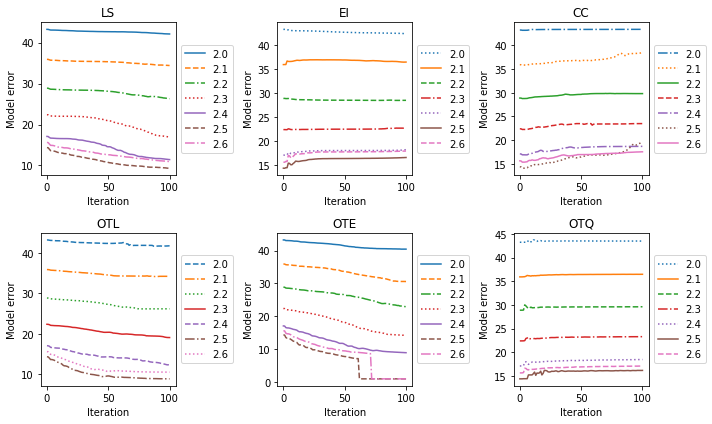

In [23]:
from itertools import cycle
SubDir2tmp = ['LS','EI','CC','OTL','OTE','OTQ']
colortmp = ['b','g','r','c','m','y','k']
lines = ["-","--","-.",":"]
linecycler = cycle(lines)
fig,ax = plt.subplots(2,3,figsize=[10,6])

for k in range(len(Str2)):
    row = k//3
    col = k-3*row
    for i in range(len(ERRORS[Str2[k]])):
        strtmp = str(2.0+0.1*i)
        ax[row][col].plot(ERRORS[Str2[k]][i],next(linecycler),label=strtmp)
        ax[row][col].set_title(SubDir2tmp[k])
        ax[row][col].set_xlabel('Iteration')
        ax[row][col].set_ylabel('Model error')
        ax[row][col].legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# savefigure(IMFigureDir + '/ModelErrorIter')

#### Best models

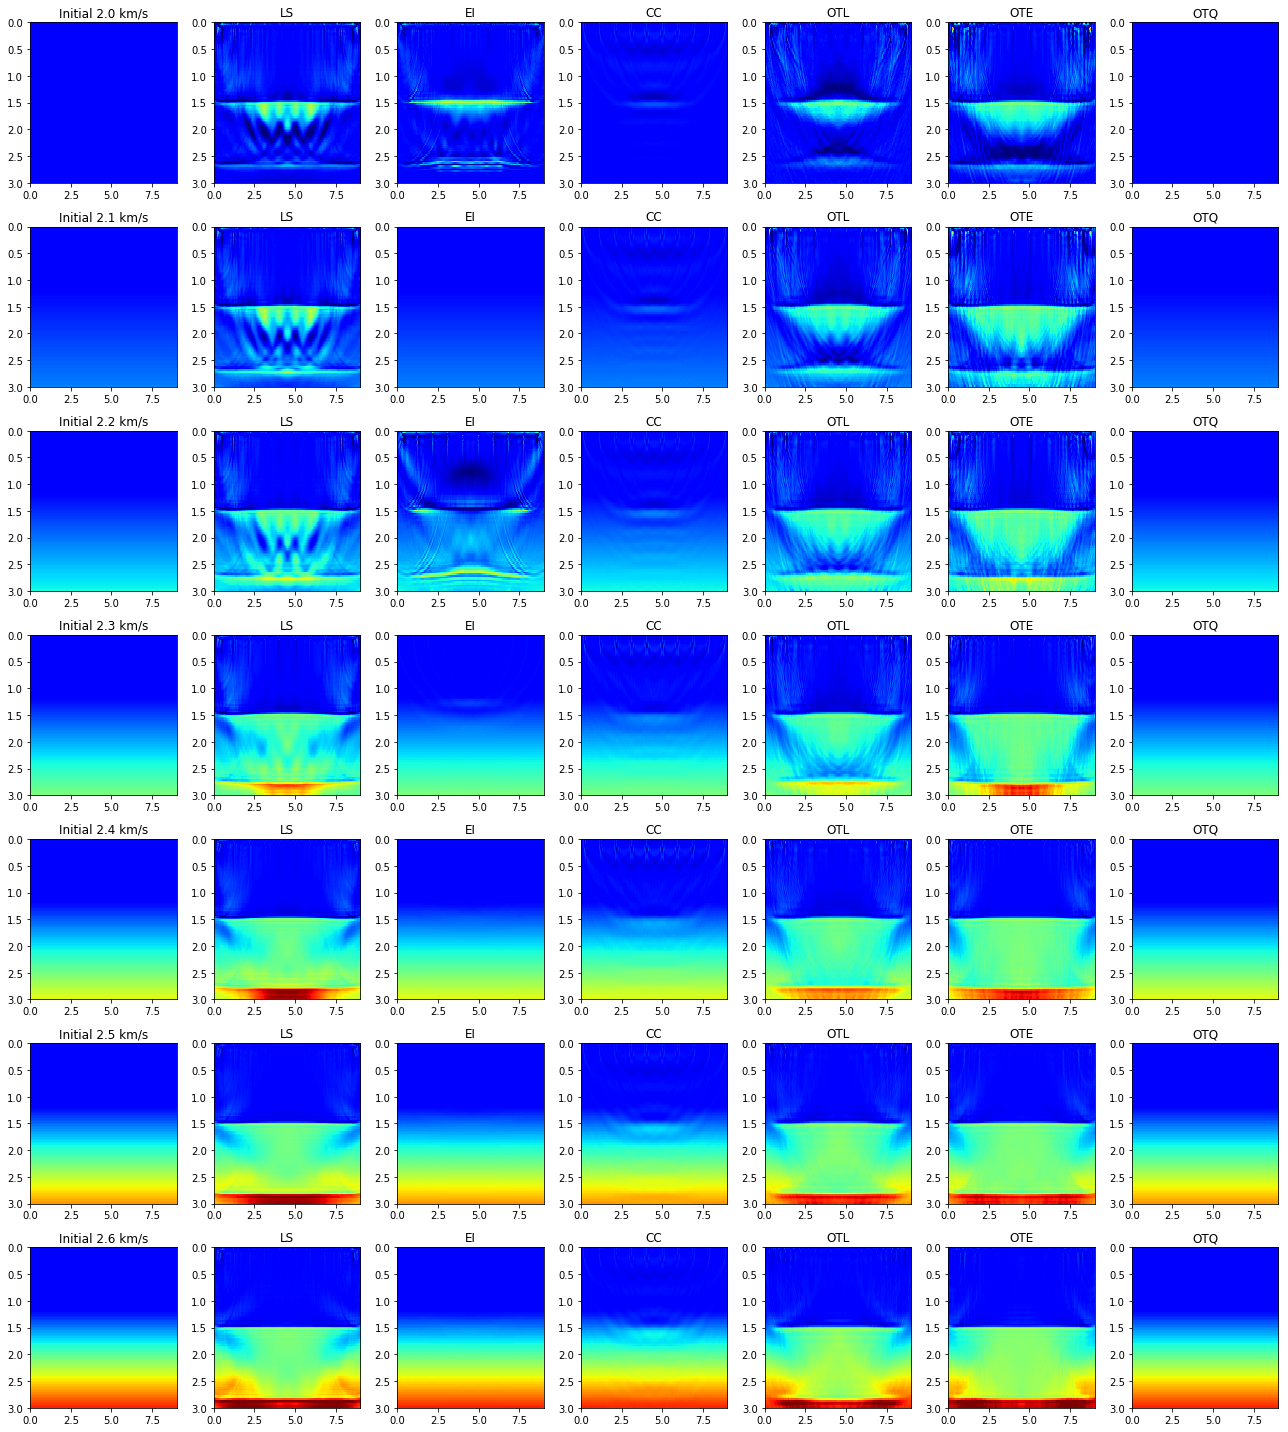

In [24]:
nrow = len(Str4)
ncol = len(Str1)
fig,ax = plt.subplots(nrow,ncol,figsize=(18,20))
Lateral = [0.0,9.0]
Depth = [0.0, 3.0]
nm = [101,301]
clim_v = [1.9,2.7]
for i in range(ncol):
    for j in range(nrow):
        vi = Vels2[i][j]
        im1=ax[i][j].imshow(vi, extent=[Lateral[0], Lateral[-1], Depth[-1], Depth[0]], clim=clim_v, interpolation='nearest', aspect='auto')
        if j == 0:
            ax[i][j].set_title(Str4[j] + ' ' + Str3[i])
        else:
            ax[i][j].set_title(Str4[j])
        im1.set_cmap('jet')
#         plot_model(fig, ax[i][j], vi, Lateral, Depth, nm, clim=clim_v, title_str=Str4[j], colorbarFlag=False)
plt.tight_layout()
FigureFile = IMFigureDir + '/IMResults'
# savefigure(FigureFile)

In [26]:
for j in range(nrow):
    fig, ax = plt.subplots(ncol, 1, figsize=(4,24))
    for i in range(ncol-1):
        vi = Vels2[i][j]
        im1=ax[i].imshow(vi, extent=[Lateral[0], Lateral[-1], Depth[-1], Depth[0]], clim=clim_v, interpolation='nearest', aspect='auto')
#         if j == 0:
        ax[i].set_title(Str3[i])
#         else:
#             ax[j].set_title(Str4[j])
        im1.set_cmap('jet')
#         plot_model(fig, ax[i][j], vi, Lateral, Depth, nm, clim=clim_v, title_str=Str4[j], colorbarFlag=False)
    FigureFile = IMFigureDir + '/IMResults_' + Str4[j]
#     savefigure(FigureFile)
    plt.close()

In [27]:
for j in range(nrow-1):
    fig, ax = plt.subplots(ncol, 1, figsize=(4,24))
    for i in range(ncol):
        vi = Vels_f[i][j].transpose()
        Errors_tmp = ERRORS[Str2[j]][i]
        im1=ax[i].imshow(vi, extent=[Lateral[0], Lateral[-1], Depth[-1], Depth[0]], clim=clim_v, interpolation='nearest', aspect='auto')
#         if j == 0:
        ax[i].set_title(Str3[i])
#         else:
#             ax[j].set_title(Str4[j])
        im1.set_cmap('jet')
        if Errors_tmp[60:80].mean() > Errors_tmp[80:100].mean():
            ax[i].scatter(0.5,0.25,s=400,marker='*',color='green')
        else:
            ax[i].scatter(0.5,0.25,s=400,marker='*',color='yellow')
#         plot_model(fig, ax[i][j], vi, Lateral, Depth, nm, clim=clim_v, title_str=Str4[j], colorbarFlag=False)

    plt.close()
    FigureFile = IMFigureDir + '/IMResults_' + Str4[j+1] + 'fm'
    print(FigureFile)
#     savefigure(FigureFile)
#     plt.close()

/math/home/fangzl/Project/Figure/ExxonProject/Paper/Journal/Reflection/InitialModelsErrors/IMResults_LSfm
/math/home/fangzl/Project/Figure/ExxonProject/Paper/Journal/Reflection/InitialModelsErrors/IMResults_EIfm
/math/home/fangzl/Project/Figure/ExxonProject/Paper/Journal/Reflection/InitialModelsErrors/IMResults_CCfm
/math/home/fangzl/Project/Figure/ExxonProject/Paper/Journal/Reflection/InitialModelsErrors/IMResults_OTLfm
/math/home/fangzl/Project/Figure/ExxonProject/Paper/Journal/Reflection/InitialModelsErrors/IMResults_OTEfm
/math/home/fangzl/Project/Figure/ExxonProject/Paper/Journal/Reflection/InitialModelsErrors/IMResults_OTQfm


#### Final models

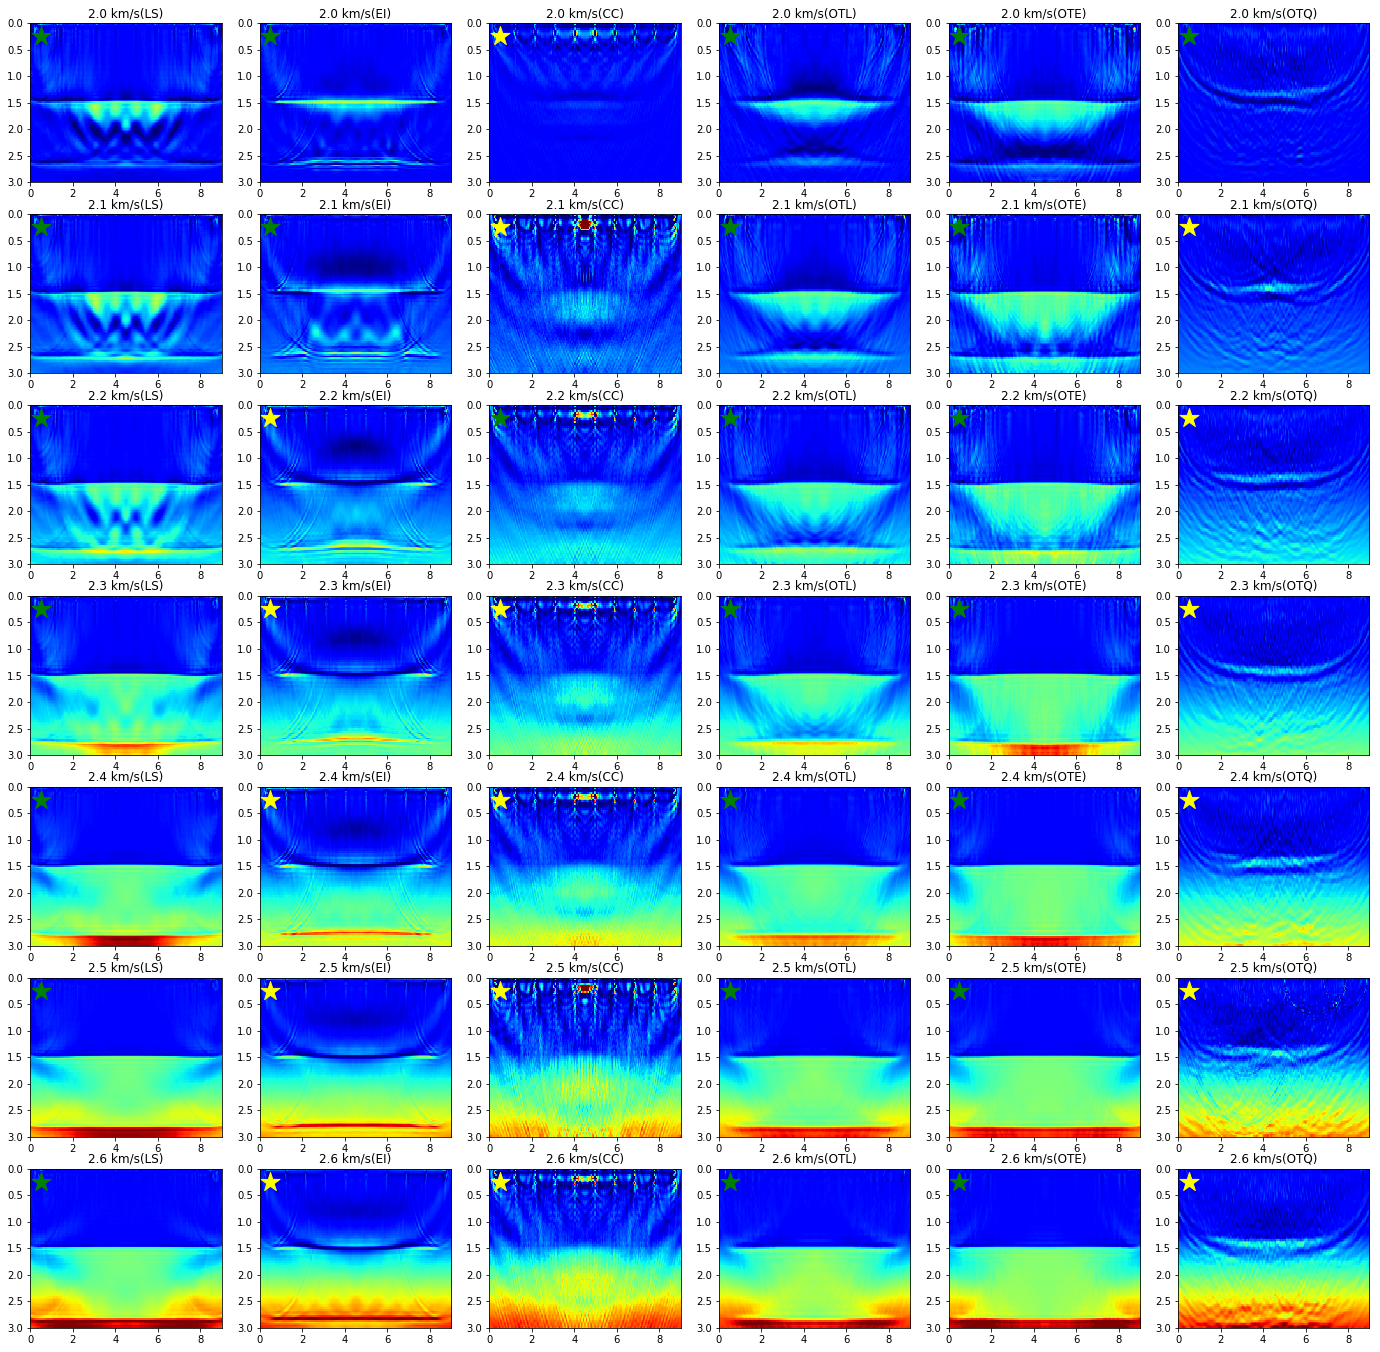

In [30]:
fig, ax = plt.subplots(ncol, nrow-1, figsize=(24,24))
for j in range(nrow-1):
    for i in range(ncol):
        vi = Vels_f[i][j].transpose()
        Errors_tmp = ERRORS[Str2[j]][i]
        im1=ax[i][j].imshow(vi, extent=[Lateral[0], Lateral[-1], Depth[-1], Depth[0]], clim=clim_v, interpolation='nearest', aspect='auto')
#         if j == 0:
        ax[i][j].set_title(Str3[i]+'('+Str4[j+1]+')')
#         else:
#             ax[j].set_title(Str4[j])
        im1.set_cmap('jet')
        if Errors_tmp[60:80].mean() > Errors_tmp[80:100].mean():
            ax[i][j].scatter(0.5,0.25,s=400,marker='*',color='green')
        else:
            ax[i][j].scatter(0.5,0.25,s=400,marker='*',color='yellow')
#         plot_model(fig, ax[i][j], vi, Lateral, Depth, nm, clim=clim_v, title_str=Str4[j], colorbarFlag=False)

#     plt.close()
#     FigureFile = IMFigureDir + '/IMResults_' + Str4[j+1] + 'fm'
#     print(FigureFile)

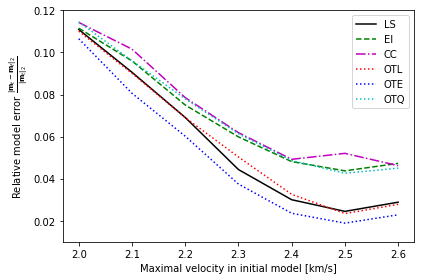

In [31]:
vt_file = IMResultDirRoot + '/' + Str1[0] + '/' + Str2[0] + '/true.mat'
vt = loaddata(vt_file)
ME = np.zeros((len(Str1), len(Str3)))


for i in range(len(Str1)):
    for j in range(len(Str2)):
        vi = Vels[i][j+1]
        ME[i,j] = (np.linalg.norm(vt.flatten() - vi.flatten())) / (np.linalg.norm(vt.flatten()))

clrs_list=['k','g','m','r','b','c'] # list of basic colors
styl_list=['-','--','-.',':',':', ':'] # list of basic linestyles
plt.figure()
xx = np.linspace(2.0, 2.6, 7)
for i in range(len(Str2)):
    clrr=clrs_list[i]
    styl=styl_list[i]
    plt.plot(xx,ME[:,i],color=clrr,ls=styl)
plt.legend(Str4[1:])
# plt.xticks(np.array(range(8)), ('1.6','1.7','1.8','1.9','2.0','2.1','2.2','2.3'))
plt.xlabel('Maximal velocity in initial model [km/s]')
# plt.ylabel('Relative model Errors')
plt.ylabel(r'Relative model error $\frac{\|\mathbf{m}_{t}-\mathbf{m}_{f}\|_2}{\|\mathbf{m}_{t}\|_2}$')
plt.ylim([0.01,0.12])
FigureFile = IMFigureDir + '/IMRelativeModelError'
plt.tight_layout()
# savefigure(FigureFile)


        

In [32]:
MEini = np.ones(len(Str1))
for i in range(len(MEini)):
    vii = Vels[i][0]
    MEini[i] = np.linalg.norm(vii.flatten() - vt.flatten()) / np.linalg.norm(vt.flatten())

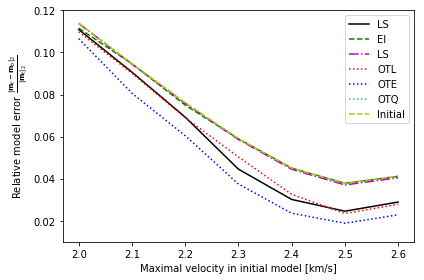

In [33]:
clrs_list=['k','g','m','r','b','c'] # list of basic colors
styl_list=['-','--','-.',':',':', ':'] # list of basic linestyles
LegendSTR = ['LS', 'EI', 'LS', 'OTL', 'OTE', 'OTQ', 'Initial']
plt.figure()
xx = np.linspace(2.0, 2.6, 7)
for i in range(len(Str2)):
    clrr=clrs_list[i]
    styl=styl_list[i]
    plt.plot(xx,model_error[:,i],color=clrr,ls=styl)
plt.plot(xx, MEini, color='y',ls='--')
plt.legend(LegendSTR)
# plt.xticks(np.array(range(8)), ('1.6','1.7','1.8','1.9','2.0','2.1','2.2','2.3'))
plt.xlabel('Maximal velocity in initial model [km/s]')
plt.ylabel(r'Relative model error $\frac{\|\mathbf{m}_{t}-\mathbf{m}_{b}\|_2}{\|\mathbf{m}_{t}\|_2}$')
plt.ylim([0.01,0.12])
FigureFile = IMFigureDir + '/IMRelativeModelError2'
plt.tight_layout()
# savefigure(FigureFile)

## 2. Starting frequency band comparison

In this example, we compare the performances of different algorithms with respect to the change of the starting frequency band. We test each method with starting frequency ranging from 1.0 Hz to 1.7 Hz.

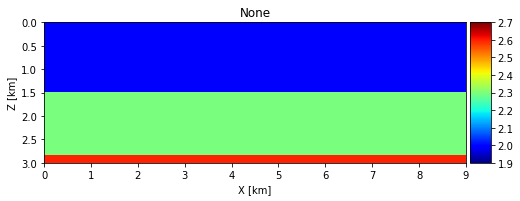

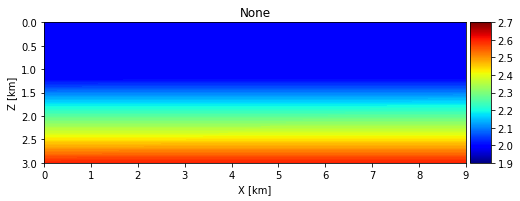

In [34]:
    ExpDir = '/wavedata/Zhilong/ExxonProject/ReflectModel/ExxonMeeting201909/Reflector_PQN2_SF'
    FigDir2 = '/math/home/fangzl/Project/Figure/ExxonProject/Paper/Journal/Reflection/StartFrequencyEIP1Model'
    SubDir1 = ['1_0', '1_2', '1_4', '1_6', '1_8', 
               '2_0', '2_2', '2_4', '2_6', '2_8',
               '3_0', '3_2', '3_4', '3_6', '3_8', 
               '4_0', '4_2', '4_4', '4_6', '4_8',
               '5_0', '5_2', '5_4', '5_6', '5_8',]
    SubDir2 = ['LS', 'EIP1', 'CC', 'OT_L', 'OT_E', 'OT_Q']
    SubDir3 = ['LS', 'EIP1', 'CC', 'OTL', 'OTE', 'OTQ']
    Labels2 = ['LS', 'ei', 'correlate', 'ot_l', 'ot_e', 'ot_q']
    
#     SubDir1 = ['1_6', '2_0', '2_1', '2_2',]
#     SubDir2 = ['CC', 'EI', 'LS', 'OT_E', 'OT_L', 'OT_Q']
    Files = ['/result.mat', '/result.mat', '/result.mat', '/result.mat', '/result.mat', '/result.mat',]
    
    vifile = ExpDir + '/Exp' + SubDir1[0] + '/' + SubDir2[0] + '/initial.mat'
    vtfile = ExpDir + '/Exp' + SubDir1[0] + '/' + SubDir2[0] + '/true.mat'
    vi, om, dm, nm = read_data(vifile)
    vt, ot, dt, nt = read_data(vtfile)
    nm = [nm[1], nm[0]]
    vi = np.reshape(vi,nm)
    vt = np.reshape(vt,nm)
    
    output = odn2grid(om, dm, nm)
    Depth = output[1]
    Lateral = output[0]
    clim_v = [1.9,2.7]
    
    fig,ax = plt.subplots(1,1,figsize=(8,4))
    plot_model(fig, ax, vt, Lateral, Depth, nm, clim=clim_v)
#     savefigure(FigDir + '/vtrue.pdf')
    
    fig,ax = plt.subplots(1,1,figsize=(8,4))
    plot_model(fig, ax, vi, Lateral, Depth, nm, clim=clim_v)
#     savefigure(FigDir + '/vin.pdf')

    

In this example, we use the ormsby wavelet whose frequency spectrum is approximately flat in a certain frquency band. The ormsby wavelet has the following expression:

$\text{Ormsby}(t) = [\frac{f_4^2}{f_4-f_3}\text{sinc}^2(f_4t) - \frac{f_3^2}{f_4-f_3}\text{sinc}^2(f_3t)] - [\frac{f_2^2}{f_2-f_1}\text{sinc}^2(f_2t) - \frac{f_1^2}{f_2-f_1}\text{sinc}^2(f_1t)].$ 

We select $f_1 = 0.5$Hz, $f_2 = 1.0$Hz, $f_3 = 10.0$Hz, $f_4 = 15.0$Hz, therefore, we obtain the source wavelet as follows:

Text(0,0.5,'Amplitude')

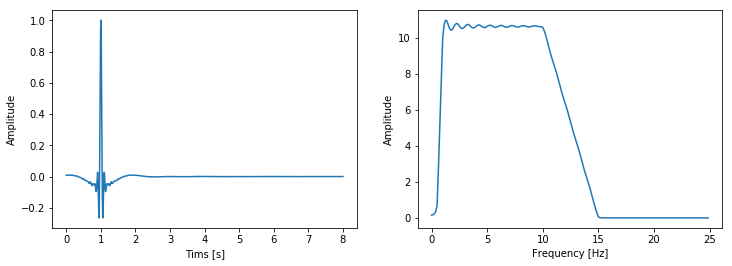

In [35]:
f1 = 0.5
f2 = 1.0
f3 = 10.0
f4 = 15.0
fig,ax=plt.subplots(1,2,figsize=(12,4))
f_src2=OrmsbySource(f1,f2,f3,f4,t_shift=1.0)
ts = np.linspace(0.0, 8.0, 2001)
src = f_src2(ts)
ax[0].plot(ts,src)
ax[0].set_xlabel('Tims [s]')
ax[0].set_ylabel('Amplitude')

spectrum = np.abs(np.fft.fft(src))
freq = np.linspace(0.0, 2000.0/8.0, 2001)
ax[1].plot(freq[0:200], spectrum[0:200])
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Amplitude')
# savefigure(FigDir + '/OrmsbySource.pdf')


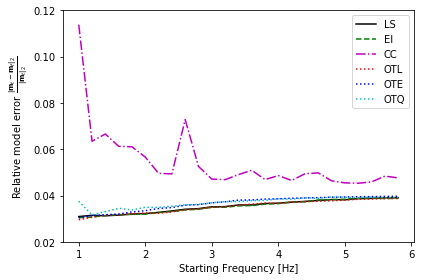

In [36]:
LegendSTR = ['LS', 'EI', 'CC', 'OTL', 'OTE', 'OTQ']
ME1 = np.ones((len(SubDir1), len(SubDir2)))
Vels = []
Objs = []
for i in range(len(SubDir1)):
    Velsi = []
    Objsi = []
    for j in range(len(SubDir2)):
        vfile = ExpDir + '/Exp' + SubDir1[i] + '/' + SubDir2[j] + Files[j]
        vij, oij, dij, nij = read_data(vfile)
        Velsi.append(vij)
        ME1[i, j] = np.linalg.norm(vij.flatten() - vt.flatten()) / np.linalg.norm(vt.flatten())
        Objsi_file = ExpDir + '/Exp' + SubDir1[i] + '/' + SubDir2[j] + '/objective_value_' + Labels2[j] + '.mat'
        objsi, otmp, dtmp, ntmp = read_data(Objsi_file)
        Objsi.append(objsi.transpose())
            
    Objs.append(Objsi)
    
    Vels.append(Velsi)

xx = np.linspace(1.0, 5.8, 25)
clrs_list=['k','g','m','r','b','c'] # list of basic colors
styl_list=['-','--','-.',':',':', ':'] # list of basic linestyles

plt.figure()
for i in range(len(SubDir2)):
    clrr=clrs_list[i]
    styl=styl_list[i]
    plt.plot(xx,ME1[:,i],color=clrr,ls=styl)
plt.legend(LegendSTR)
# plt.xticks(np.array(range(8)), ('1.6','1.7','1.8','1.9','2.0','2.1','2.2','2.3'))
plt.xlabel('Starting Frequency [Hz]')
# plt.ylabel('Model error')
plt.ylabel(r'Relative model error $\frac{\|\mathbf{m}_{t}-\mathbf{m}_{f}\|_2}{\|\mathbf{m}_{t}\|_2}$')
plt.ylim([0.02,0.12])
FigureFile = FigDir2 + '/model_error'
plt.tight_layout()

# savefigure(FigureFile)


In [37]:
    vt_file = IMResultDirRoot + '/' + Str1[0] + '/' + Str2[0] + '/true.mat'
    vt = loaddata(vt_file)
    model_error = np.zeros((len(SubDir1), len(SubDir2)))
    model_error_f = np.zeros((len(SubDir1), len(SubDir2)))
    Vels2 = []
    Vels_f = []
    ERRORS = dict()
    for i in range(len(SubDir2)):
        ERRORS[SubDir2[i]] = []
    for i in range(len(SubDir1)):
        Velsi = []
        Velsi_f = []
        for j in range(len(SubDir2)):
#             vij_file = ExpDir + '/Exp' + SubDir1[i] + '/' + SubDir2[j] 
#             vij, otmp, dtmp, ntmp = read_data(vij_file)
#             model_error_f[i][j] = np.linalg.norm(vij.transpose().flatten() - vt.flatten())/ np.linalg.norm(vt.flatten())
#             Velsi_f.append(vij.transpose())
            
            
            Error = 1e10
            opt_k = 0
            Errors = np.ones(51)
            for k in range(51):
#                 vijk_file = ExpDir + '/Exp' + SubDir1[i] + '/' + SubDir2[j] + '/xm/x_' + str(k) + '.mat'
                vijk_file = ExpDir + '/Exp' + SubDir1[i] + '/' + SubDir2[j] + '/xm/x_' + str(k) + '.mat'
                if os.path.isfile(vijk_file) is True:
                    A = sio.loadmat(vijk_file)
                    vijk = A['data']
                    vijk = np.reshape(vijk,[301,101]).transpose()
                    Errori = np.linalg.norm(vijk.flatten() - vt.flatten())
                    Errors[k] = Errori
                    if Errori < Error:
                        Error = Errori
                        vij = vijk
                        opt_k = k
            write_data(ExpDir + '/Exp' + SubDir1[i] + '/' + SubDir2[j] + '/model_error.mat',Errors, 0,1,len(Errors))
            ERRORS[Str2[j]].append(Errors)
                    
            print(opt_k,end=",  ")
#             vij, otmp, dtmp, ntmp = read_data(vij_file)
            vij = vij.transpose()
            model_error[i][j] = np.linalg.norm(vij.transpose().flatten() - vt.flatten()) / np.linalg.norm(vt.flatten())
            Velsi.append(vij.transpose())
        Vels2.append(Velsi)
        Vels_f.append(Velsi_f)

49,  50,  1,  49,  36,  48,  49,  50,  1,  44,  16,  50,  50,  50,  1,  50,  33,  50,  50,  50,  1,  50,  36,  46,  50,  50,  1,  48,  27,  50,  50,  50,  1,  50,  26,  50,  50,  50,  1,  50,  23,  50,  48,  50,  1,  50,  24,  50,  50,  50,  1,  50,  24,  50,  50,  50,  1,  50,  23,  50,  50,  50,  1,  50,  23,  50,  50,  50,  1,  50,  22,  50,  50,  50,  1,  50,  18,  50,  50,  50,  1,  49,  18,  50,  50,  50,  1,  50,  14,  50,  49,  49,  1,  50,  15,  49,  50,  50,  1,  50,  14,  50,  49,  50,  1,  50,  14,  50,  50,  50,  1,  46,  14,  50,  50,  50,  1,  50,  13,  50,  50,  50,  1,  50,  12,  50,  50,  50,  1,  50,  12,  50,  50,  50,  1,  50,  12,  48,  49,  50,  1,  50,  12,  50,  50,  50,  1,  50,  11,  50,  

#### Iteration histories

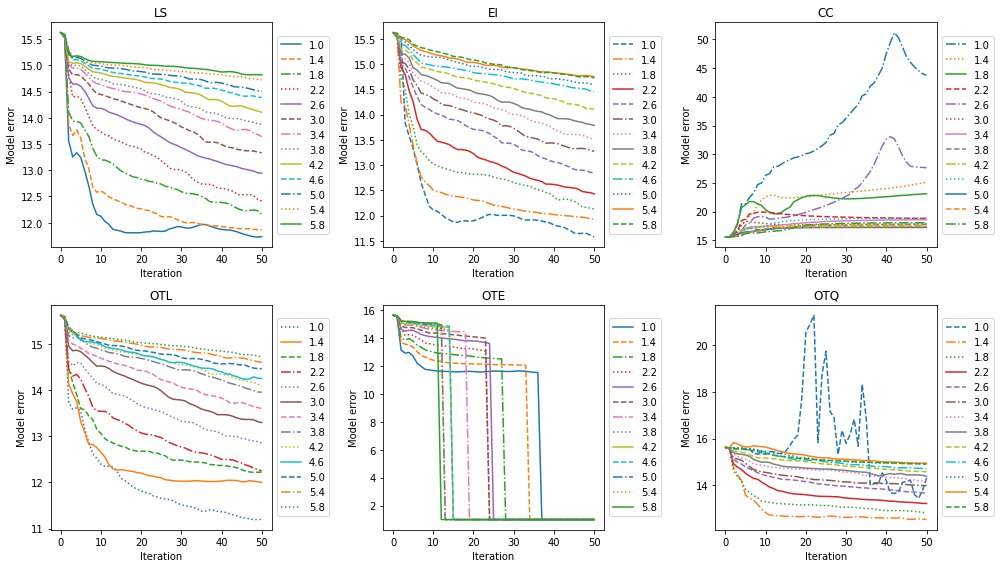

In [38]:
colortmp = ['b','g','r','c','m','y','k']
lines = ["-","--","-.",":"]
linecycler = cycle(lines)
fig,ax = plt.subplots(2,3,figsize=[14,8])

for k in range(len(SubDir2)):
    row = k//3
    col = k-3*row
    for i in range(0,len(ERRORS[SubDir2[k]]),2):
        strtmp = str(round(1.0+0.1*2*i,1))
        ax[row][col].plot(ERRORS[SubDir2[k]][i],next(linecycler),label=strtmp)
        ax[row][col].set_title(SubDir2[k])
        ax[row][col].set_title(SubDir2tmp[k])
        ax[row][col].set_xlabel('Iteration')
        ax[row][col].set_ylabel('Model error')
        ax[row][col].legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# savefigure(FigDir2 + '/ModelErrorIter')

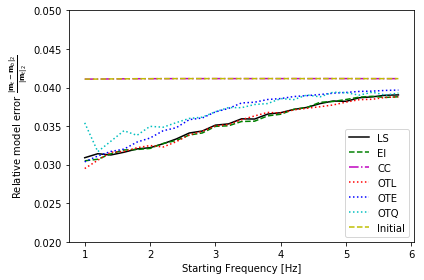

In [39]:
# LegendSTR = ['CC', 'EI', 'LS', 'OTE', 'OTL', 'OTQ', 'Initial']
LegendSTR = ['LS', 'EI', 'CC', 'OTL', 'OTE', 'OTQ', 'Initial']
plt.figure()
for i in range(len(SubDir2)):
    clrr=clrs_list[i]
    styl=styl_list[i]
    plt.plot(xx,model_error[:,i],color=clrr,ls=styl)
plt.plot(xx,model_error[:,2],color='y',ls='--')
plt.legend(LegendSTR)
# plt.xticks(np.array(range(8)), ('1.6','1.7','1.8','1.9','2.0','2.1','2.2','2.3'))
plt.xlabel('Starting Frequency [Hz]')
# plt.ylabel('Model error')
plt.ylabel(r'Relative model error $\frac{\|\mathbf{m}_{t}-\mathbf{m}_{b}\|_2}{\|\mathbf{m}_{t}\|_2}$')
plt.ylim([0.02,0.12])
plt.ylim([0.02,0.05])
FigureFile = FigDir2 + '/model_error2'
plt.tight_layout()

# savefigure(FigureFile)

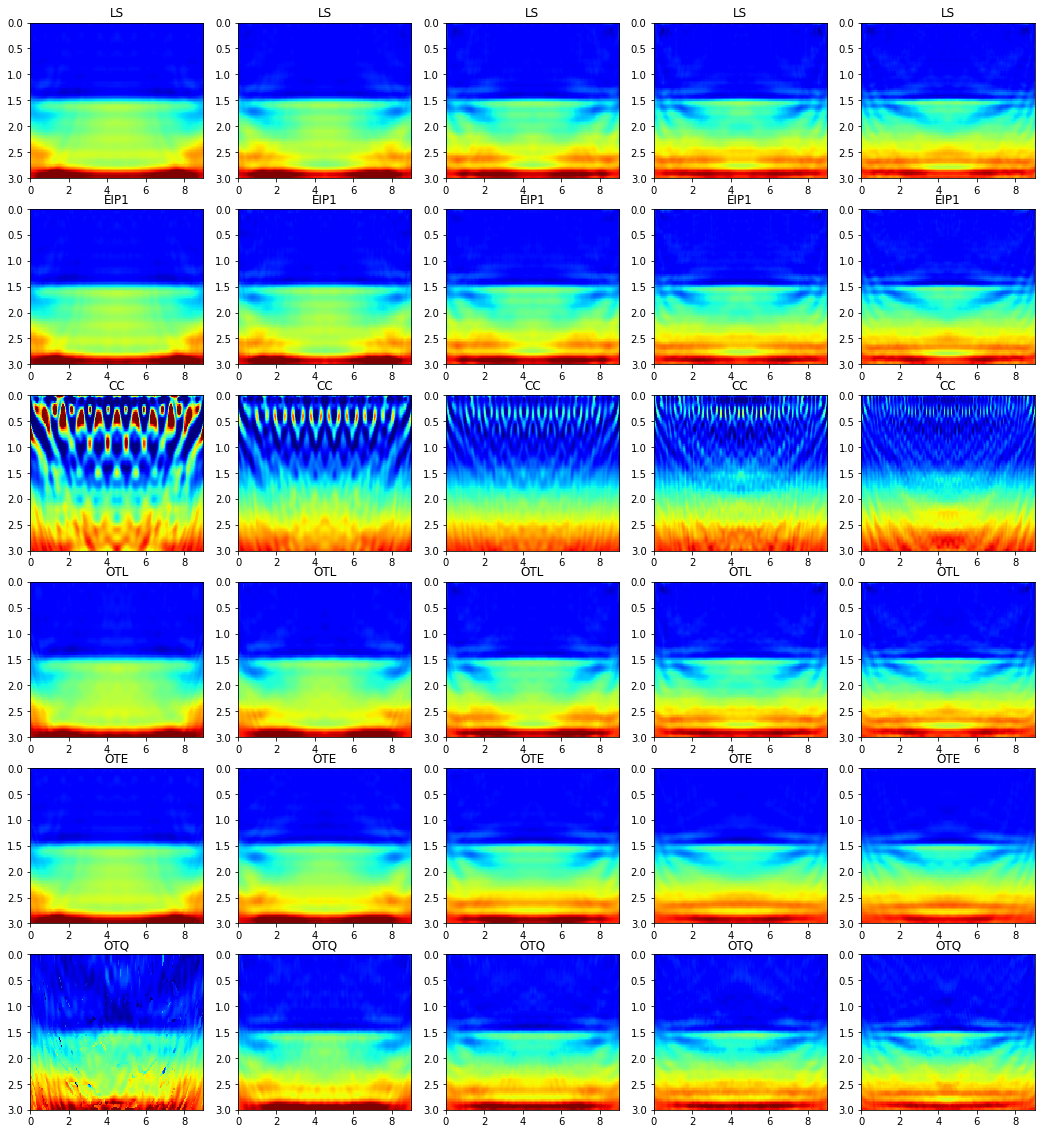

In [40]:
kkk = [0,5,10,15,20]
# nrow = len(kkk)
nrow = len(SubDir2)
ncol = len(kkk)
# ncol = len(xx)
fig,ax = plt.subplots(nrow,ncol,figsize=(18,20))
for i in range(ncol):
    for j in range(nrow):
        vi = Vels[kkk[i]][j]
        im1=ax[j][i].imshow(vi, extent=[Lateral[0], Lateral[-1], Depth[-1], Depth[0]], clim=clim_v, interpolation='nearest', aspect='auto')
        ax[j][i].set_title(SubDir3[j])
        im1.set_cmap('jet')
#         plot_model(fig, ax[i][j], vi, Lateral, Depth, nm, clim=clim_v, title_str=Str4[j], colorbarFlag=False)
FigureFile = FigDir + '/SFResults'
# savefigure(FigureFile)

In [41]:
kkk = [0,5,10,15,20]
nrow = len(SubDir2)
ncol = len(kkk)
# ncol = len(xx)

for j in range(nrow):
    fig,ax = plt.subplots(ncol,1,figsize=(4,25))
    for i in range(ncol):
        vi = Vels[kkk[i]][j]
        Errors_tmp = ERRORS[SubDir2[j]][kkk[i]]
        im1=ax[i].imshow(vi, extent=[Lateral[0], Lateral[-1], Depth[-1], Depth[0]], clim=clim_v, interpolation='nearest', aspect='auto')
        ax[i].set_title('SF = {0} Hz'.format(round(xx[kkk[i]])))
        ax[i].set_xlabel('X [km]')
        ax[i].set_ylabel('Z [km]')
        im1.set_cmap('jet')
        if Errors_tmp[10:30].mean() > Errors_tmp[31:51].mean():
            ax[i].scatter(0.5,0.25,s=400,marker='*',color='green')
        else:
            ax[i].scatter(0.5,0.25,s=400,marker='*',color='yellow')
#         plot_model(fig, ax[i][j], vi, Lateral, Depth, nm, clim=clim_v, title_str=Str4[j], colorbarFlag=False)
    FigureFile = FigDir2 + '/SFResults_' + SubDir2[j]+'fm'
#     savefigure(FigureFile)
    plt.close()

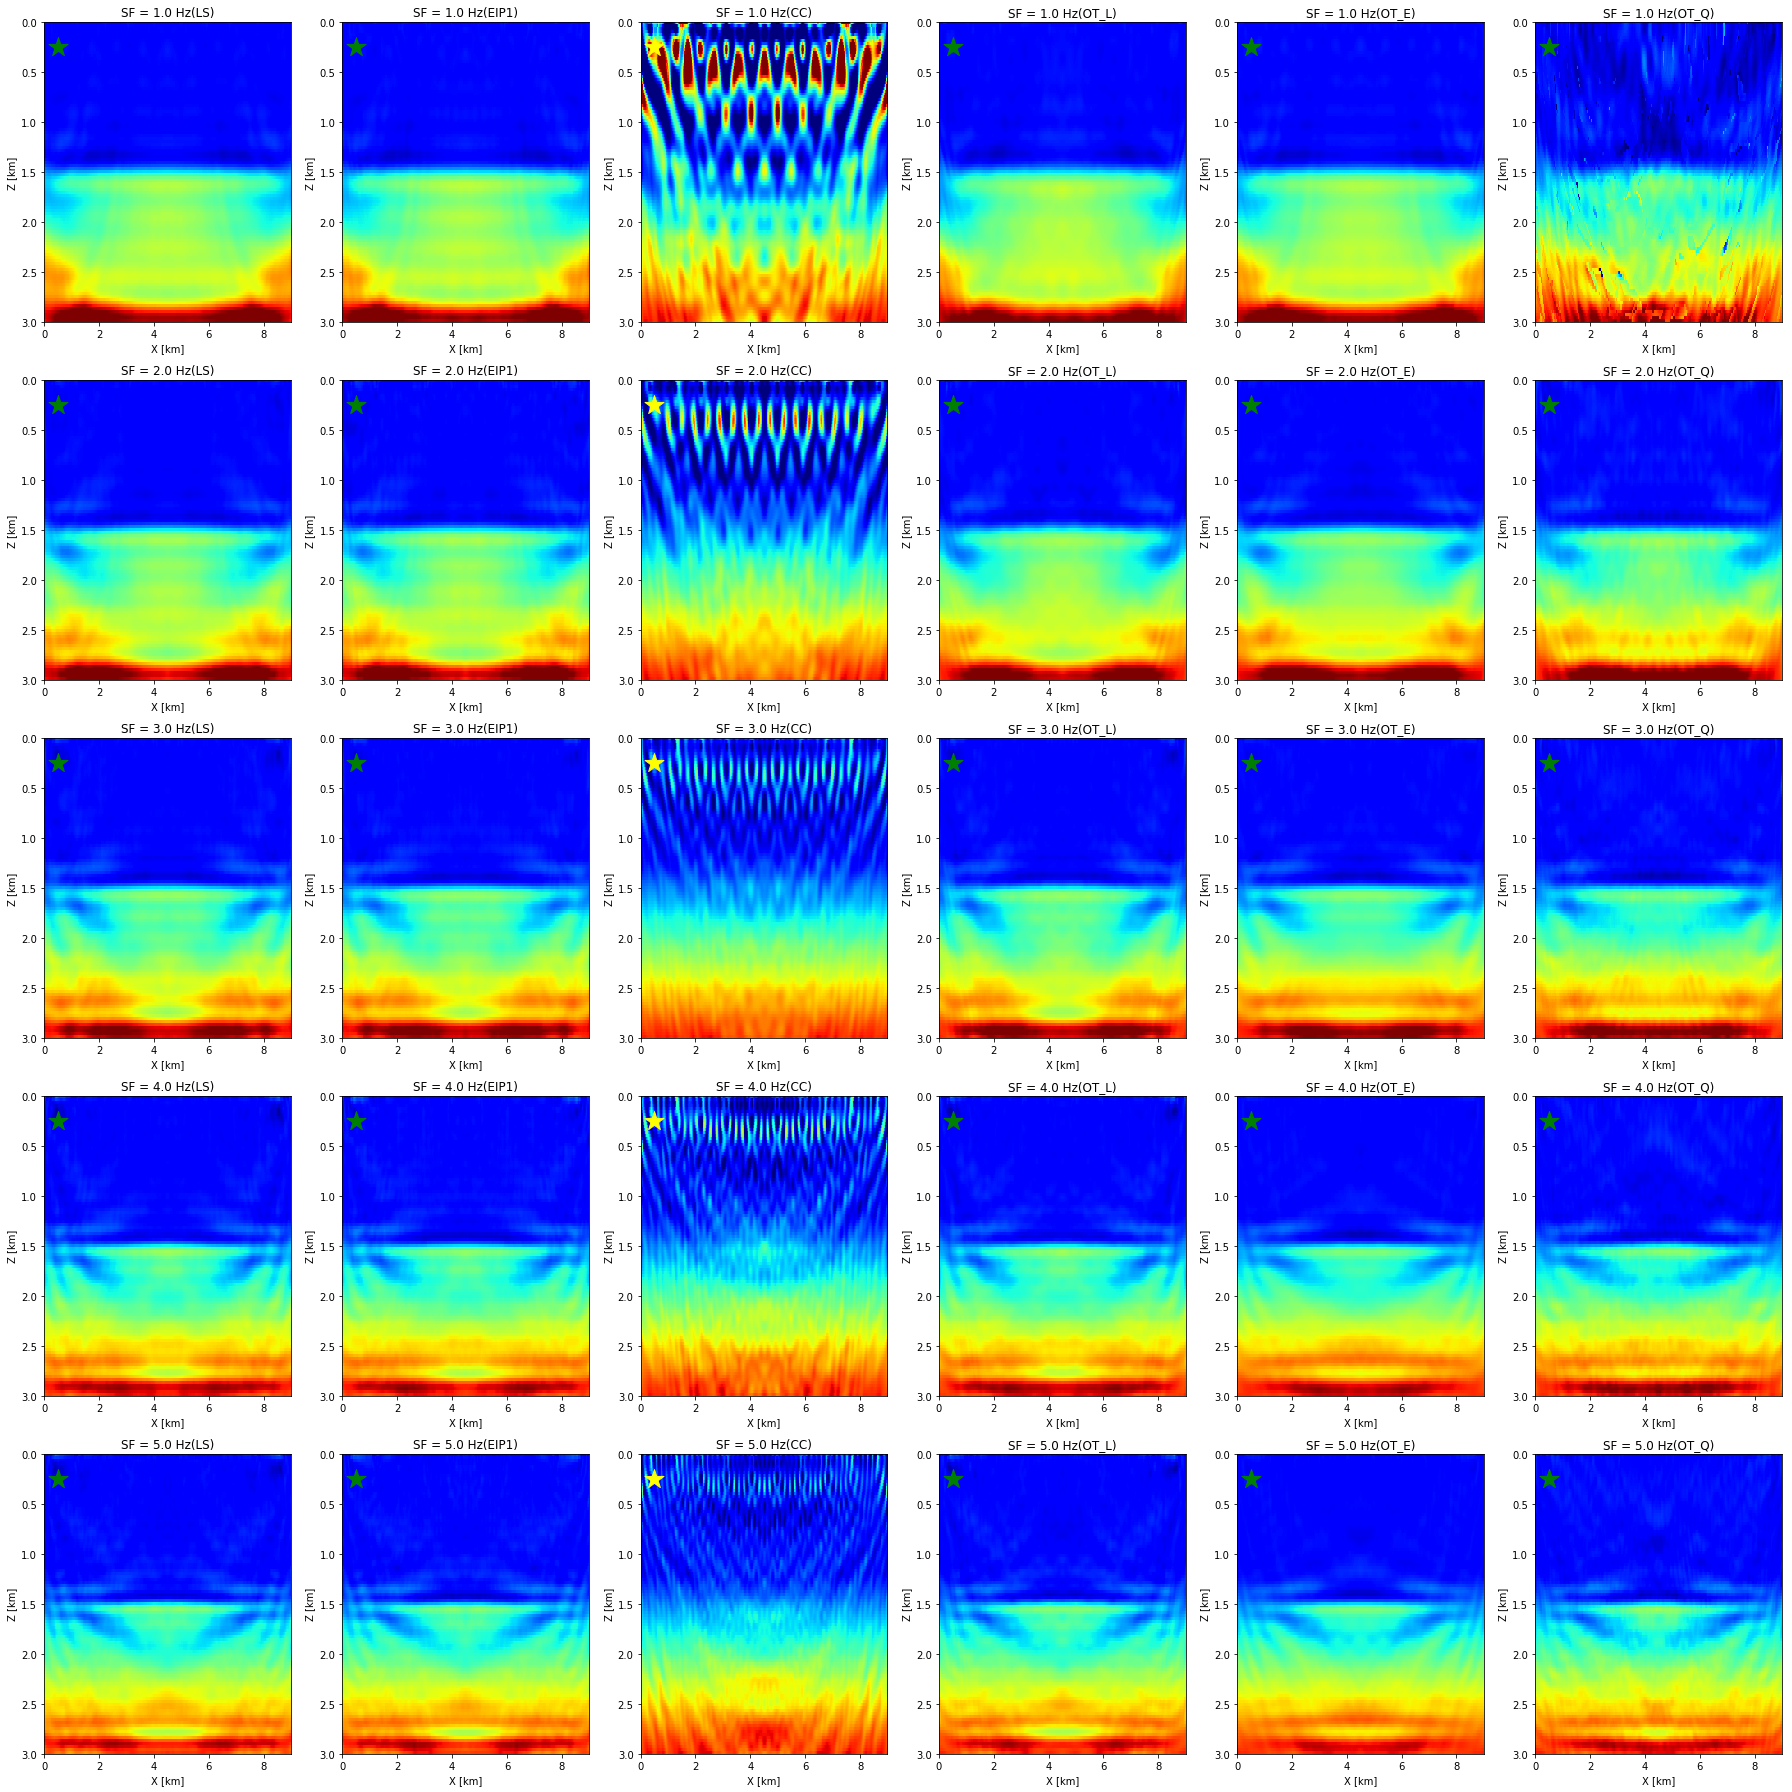

In [45]:
fig,ax = plt.subplots(ncol,nrow,figsize=(25,25))
for j in range(nrow):
    for i in range(ncol):
        vi = Vels[kkk[i]][j]
        Errors_tmp = ERRORS[SubDir2[j]][kkk[i]]
        im1=ax[i][j].imshow(vi, extent=[Lateral[0], Lateral[-1], Depth[-1], Depth[0]], clim=clim_v, interpolation='nearest', aspect='auto')
        ax[i][j].set_title('SF = {0} Hz'.format(round(xx[kkk[i]])) + '('+SubDir2[j]+')')
        ax[i][j].set_xlabel('X [km]')
        ax[i][j].set_ylabel('Z [km]')
        im1.set_cmap('jet')
        if Errors_tmp[10:30].mean() > Errors_tmp[31:51].mean():
            ax[i][j].scatter(0.5,0.25,s=400,marker='*',color='green')
        else:
            ax[i][j].scatter(0.5,0.25,s=400,marker='*',color='yellow')
#         plot_model(fig, ax[i][j], vi, Lateral, Depth, nm, clim=clim_v, title_str=Str4[j], colorbarFlag=False)
#     FigureFile = FigDir2 + '/SFResults_' + SubDir2[j]+'fm'
#     savefigure(FigureFile)
#     plt.close()
plt.tight_layout()

In [44]:
Ftitle = []
for i in range(0,len(xx)):
    Ftitle.append('Starting frequency = '+str(xx[i])+' Hz')
    
ani = create_animation_model_transmission(Vels, SubDir2, frametitle=Ftitle,  ksmp=1)
HTML(ani.to_html5_video())

<Figure size 432x288 with 0 Axes>